In [1]:
!pip install -q kaggle

In [2]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json
!kaggle datasets download -d muhammadhananasghar/human-emotions-datasethes

cp: cannot stat 'kaggle.json': No such file or directory
chmod: cannot access '/root/.kaggle/kaggle.json': No such file or directory
Dataset URL: https://www.kaggle.com/datasets/muhammadhananasghar/human-emotions-datasethes
License(s): unknown
 97% 300M/309M [00:02<00:00, 139MB/s]
100% 309M/309M [00:02<00:00, 122MB/s]


In [3]:
!unzip "/content/human-emotions-datasethes" -d "/content/dataset/"

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/EmotionsDataset/data/nothing/720.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/721.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/722.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/723.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/724.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/725.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/726.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/727.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/728.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/729.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/73.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/730.jpg  
  inflating: /content/dataset/EmotionsDataset/data/nothing/731.jpg  
  inflating: /content/dataset/EmotionsDataset/data/no

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import cv2
import numpy as np
from tensorflow.keras.layers import (Resizing, Rescaling, InputLayer, Conv2D, BatchNormalization, MaxPool2D, Flatten, Dense, Dropout, Permute,
                                     Input, RandomRotation, RandomFlip, RandomContrast, Layer, Add, Activation, GlobalAveragePooling2D, Embedding, MultiHeadAttention, LayerNormalization)
from tensorflow.keras.regularizers import L2
from tensorflow.keras.models import Model
from tensorflow.keras.losses import CategoricalCrossentropy
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import CategoricalAccuracy, TopKCategoricalAccuracy
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.callbacks import Callback
from sklearn.metrics import confusion_matrix
import seaborn as sns
import tensorflow_probability as tfp

In [5]:
train_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/train"
validation_directory = "/content/dataset/Emotions Dataset/Emotions Dataset/test"
CLASS_NAMES = ['angry', 'happy', 'sad']

Config = {
    "batch_size": 32,
    "im_size":256,
    "learning_rate": 0.001,
    "n_epochs": 20,
    "dropout_rate": 0.0,
    "regularization_rate": 0.0,
    "n_filters": 6,
    "kernel_size": 3,
    "n_dense_1": 100,
    "n_dense_2": 10,
    "pool_size": 2,
    "n_strides": 1,
    "num_classes": 3,
    "patch_size": 16,
    "proj_dim": 768,
}

In [6]:
train_dataset = tf.keras.utils.image_dataset_from_directory(
    train_directory,
    labels='inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256, 256),
    shuffle = True,
    seed = 99,
)

Found 6799 files belonging to 3 classes.


In [7]:
val_dataset = tf.keras.utils.image_dataset_from_directory(
    validation_directory,
    labels='inferred',
    label_mode = 'categorical',
    class_names = CLASS_NAMES,
    color_mode = 'rgb',
    batch_size = 32,
    image_size = (256, 256),
    shuffle = True,
    seed = 99,
)

Found 2278 files belonging to 3 classes.


Patch Encoding

In [8]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (Config["im_size"] ,Config["im_size"]))

In [9]:
patches = tf.image.extract_patches(images=tf.expand_dims(test_image, axis = 0),
                           sizes=[1, Config["patch_size"], Config["patch_size"], 1],
                           strides=[1, Config["patch_size"], Config["patch_size"], 1],
                           rates=[1, 1, 1, 1],
                           padding='VALID')

In [10]:
print(patches.shape)
patches = tf.reshape(patches, (patches.shape[0], -1, 768))
print(patches.shape)

(1, 16, 16, 768)
(1, 256, 768)


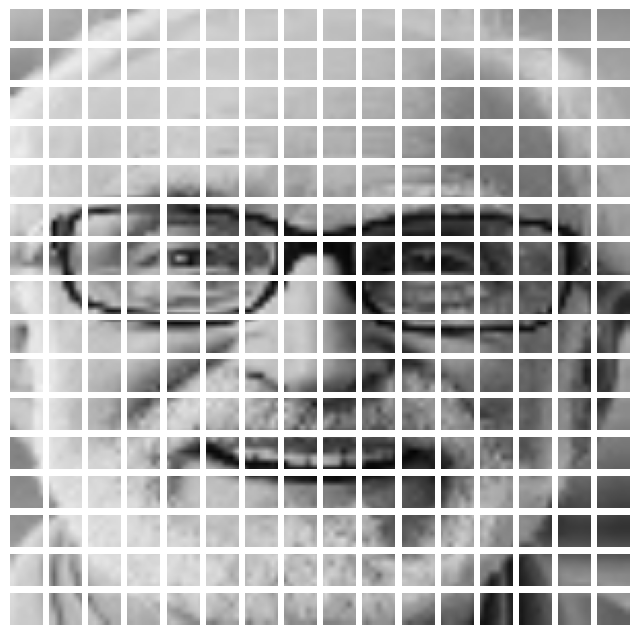

In [11]:
plt.figure(figsize = (8,8))

for i in range(patches.shape[1]):

    ax = plt.subplot(16,16, i+1)
    plt.imshow(tf.reshape(patches[0,i,:], (16,16,3)))
    plt.axis("off")

In [12]:
class PatchEncoder(Layer):
  def __init__(self, N_PATCHES, HIDDEN_SIZE):
    super(PatchEncoder, self).__init__(name = 'patch_encoder')

    self.linear_projection = Dense(HIDDEN_SIZE)
    self.positional_embedding = Embedding(N_PATCHES, HIDDEN_SIZE )
    self.N_PATCHES = N_PATCHES

  def call(self, x):
    patches = tf.image.extract_patches(
        images=x,
        sizes=[1, Config["patch_size"], Config["patch_size"], 1],
        strides=[1, Config["patch_size"], Config["patch_size"], 1],
        rates=[1, 1, 1, 1],
        padding='VALID')

    patches = tf.reshape(patches, (tf.shape(patches)[0], 256, patches.shape[-1]))

    embedding_input = tf.range(start = 0, limit = self.N_PATCHES, delta = 1 )
    output = self.linear_projection(patches) + self.positional_embedding(embedding_input)

    return output

In [13]:
patch_enc = PatchEncoder(256, 768)
patch_enc(tf.zeros([1,256,256,3]))

<tf.Tensor: shape=(1, 256, 768), dtype=float32, numpy=
array([[[ 0.03928937,  0.03138741,  0.00509201, ..., -0.01986235,
         -0.01048336, -0.01610812],
        [-0.01895424,  0.03270957, -0.0455176 , ..., -0.01056447,
          0.04358958,  0.04689939],
        [-0.03916757,  0.03124572,  0.01837626, ...,  0.02167261,
          0.00920597, -0.00322513],
        ...,
        [-0.04035705,  0.00967268,  0.0117802 , ...,  0.02780621,
         -0.00047405,  0.04587411],
        [-0.0425002 , -0.03097458,  0.01398906, ..., -0.01272762,
          0.00345923, -0.03969713],
        [ 0.03894404, -0.01020074,  0.03412675, ...,  0.02427648,
          0.00478156,  0.0149604 ]]], dtype=float32)>

Transformer Encoding

In [14]:
class TransformerEncoder(Layer):
  def __init__(self, N_HEADS, HIDDEN_SIZE):
    super(TransformerEncoder, self).__init__(name = 'transformer_encoder')

    self.layer_norm_1 = LayerNormalization()
    self.layer_norm_2 = LayerNormalization()

    self.multi_head_att = MultiHeadAttention(N_HEADS, HIDDEN_SIZE )

    self.dense_1 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)
    self.dense_2 = Dense(HIDDEN_SIZE, activation = tf.nn.gelu)

  def call(self, input):
    x_1 = self.layer_norm_1(input)
    x_1 = self.multi_head_att(x_1, x_1)

    x_1 = Add()([x_1, input])

    x_2 = self.layer_norm_2(x_1)
    x_2 = self.dense_1(x_2)
    output = self.dense_2(x_2)
    output = Add()([output, x_1])

    return output

ViT

In [15]:
class ViT(Model):
  def __init__(self, N_HEADS, HIDDEN_SIZE, N_PATCHES, N_LAYERS, N_DENSE_UNITS):
    super(ViT, self).__init__(name = 'vision_transformer')
    self.N_LAYERS = N_LAYERS
    self.patch_encoder = PatchEncoder(N_PATCHES, HIDDEN_SIZE)
    self.trans_encoders = [TransformerEncoder(N_HEADS, HIDDEN_SIZE) for _ in range(N_LAYERS)]
    self.dense_1 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_2 = Dense(N_DENSE_UNITS, tf.nn.gelu)
    self.dense_3 = Dense(Config["num_classes"], activation = 'softmax')
  def call(self, input, training = True):

    x = self.patch_encoder(input)

    for i in range(self.N_LAYERS):
      x = self.trans_encoders[i](x)
    x = Flatten()(x)
    x = self.dense_1(x)
    x = self.dense_2(x)

    return self.dense_3(x)

In [16]:
vit = ViT(
    N_HEADS = 4, HIDDEN_SIZE = 768, N_PATCHES = 256,
    N_LAYERS = 2, N_DENSE_UNITS = 128)
vit(tf.zeros([2,256,256,3]))

<tf.Tensor: shape=(2, 3), dtype=float32, numpy=
array([[0.29387286, 0.21475393, 0.49137312],
       [0.29387292, 0.21475402, 0.49137312]], dtype=float32)>

In [17]:
vit.summary()

Model: "vision_transformer"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 patch_encoder (PatchEncode  multiple                  787200    
 r)                                                              
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 transformer_encoder (Trans  multiple                  10631424  
 formerEncoder)                                                  
                                                                 
 dense_6 (Dense)             multiple                  25165952  
                                                                 
 dense_7 (Dense)             multiple                  16512     
                                                

In [18]:
loss = CategoricalCrossentropy()

In [19]:
metrics = [CategoricalAccuracy(name = "accuracy"), TopKCategoricalAccuracy(k=2, name = "top_k_accuracy")]

In [20]:
vit.compile(optimizer = Adam(learning_rate= Config['learning_rate']),
            loss = loss,
            metrics = metrics)

In [21]:
history = vit.fit(train_dataset, validation_data = val_dataset, epochs = Config['n_epochs'], verbose = 1,)

  5/213 [..............................] - ETA: 1:38:11 - loss: 17618.3691 - accuracy: 0.3688 - top_k_accuracy: 0.9812

KeyboardInterrupt: 

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train_loss', 'val_loss'])
plt.show()

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train_accuracy', 'val_accuracy'])
plt.show()

# HuggingFace Transformers

In [22]:
!pip install transformers

In [23]:
resize_rescale_hf = tf.keras.Sequential([
       Resizing(224, 224),
       Rescaling(1./255),
       Permute((3,1,2))
])

In [24]:
from transformers import ViTFeatureExtractor, TFViTModel


base_model = TFViTModel.from_pretrained("google/vit-base-patch16-224-in21k")

inputs = Input(shape = (256,256,3))
x = resize_rescale_hf(inputs)
x = base_model.vit(x)[0][:,0,:]
#print(x)
output = Dense(Config["num_classes"], activation = 'softmax')(x)

hf_model = tf.keras.Model(inputs=inputs, outputs=output)

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/502 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/346M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFViTModel.

All the weights of TFViTModel were initialized from the PyTorch model.
If your task is similar to the task the model of the checkpoint was trained on, you can already use TFViTModel for predictions without further training.


In [25]:
test_image = cv2.imread("/content/dataset/Emotions Dataset/Emotions Dataset/train/happy/387249.jpg")
test_image = cv2.resize(test_image, (Config["im_size"] ,Config["im_size"]))

In [26]:
hf_model(tf.expand_dims(test_image, axis = 0))

<tf.Tensor: shape=(1, 3), dtype=float32, numpy=array([[0.32497102, 0.38661554, 0.2884134 ]], dtype=float32)>

In [27]:
hf_model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 3)]        0         []                            
                                                                                                  
 sequential (Sequential)     (None, 3, 224, 224)          0         ['input_1[0][0]']             
                                                                                                  
 tf.compat.v1.transpose (TF  (None, 224, 224, 3)          0         ['sequential[0][0]']          
 OpLambda)                                                                                        
                                                                                                  
 tf.compat.v1.shape (TFOpLa  (4,)                         0         ['sequential[0][0]']      

In [28]:
hf_model.compile(optimizer = Adam(learning_rate= 5e-5),
            loss = loss,
            metrics = metrics)

In [ ]:
history = hf_model.fit(train_dataset, validation_data = val_dataset, epochs = Config['n_epochs'], verbose = 1)

  1/213 [..............................] - ETA: 2:16:16 - loss: 1.1113 - accuracy: 0.3438 - top_k_accuracy: 0.9330